# Smart Grocery Recommendation System

**Problem statement:**

*How this should work is that artificial intelligence customized by big data methods will enhance customers to experience efficient, personalized, and adaptive product suggestions when buying groceries.*


---

To find the solution for the above
problem statement, we need to undergo
extensive data analysis processes to transfrom the extracted raw data into meaning insights. The following jupyter notebook will demonstrate the same.

**1) Dataset Description**



*   Name: Groceries data train


*   User id:	int64	Unique identifier for the customer who made a purchase.
*   Date:	object	Transaction date in DD-MM-YYYY format.

*   Item Description:	object	Name of the purchased grocery item (e.g., whole milk, tropical fruit).
*   year:	int64	Year of the transaction (mostly 2014, with some in 2015).


*   month:	int64	Month of the transaction (1 = January, ..., 12 = December).
*   day:	int64	Day of the month the transaction occurred (1 to 31).


*   Day of week:	int64	Day of the week (0 = Sunday, 1 = Monday, ..., 6 = Saturday).









In [1]:
#Read the dataset
import pandas as pd
import numpy as np
df = pd.read_csv('Groceries data train.csv')

#dataset dimentions
print("The dataset has {} rows and {} columns \n".format(df.shape[0],df.shape[1]))
df.head(5)

The dataset has 19382 rows and 7 columns 



,User_id,Date,itemDescription,year,month,day,day_of_week
0,2351,01-01-2014,cleaner,2014,1,1,2
1,2226,01-01-2014,sausage,2014,1,1,2
2,1922,01-01-2014,tropical fruit,2014,1,1,2
3,2943,01-01-2014,whole milk,2014,1,1,2
4,1249,01-01-2014,citrus fruit,2014,1,1,2


Dataset collected from multiple retail transactions across various stores in Australia. Each record represents a single purchase transaction. That means each record shows each transaction per day.

In [2]:
#checking the datatype of the features
print("The datatype of the features are: \n")
print(df.dtypes)

#dataset statistics
import math
print("\nUnderstanding the basic univariate statistics of the data used: \n")
print(round(df.describe(),1))

The datatype of the features are: 

User_id             int64
Date               object
itemDescription    object
year                int64
month               int64
day                 int64
day_of_week         int64
dtype: object

Understanding the basic univariate statistics of the data used: 

       User_id     year    month      day  day_of_week
count  19382.0  19382.0  19382.0  19382.0      19382.0
mean    3009.1   2014.1      6.2     15.4          3.0
std     1158.1      0.2      3.6      8.8          2.0
min     1000.0   2014.0      1.0      1.0          0.0
25%     1998.0   2014.0      3.0      8.0          1.0
50%     3015.5   2014.0      6.0     15.0          3.0
75%     4025.0   2014.0      9.0     23.0          5.0
max     5000.0   2015.0     12.0     31.0          6.0


The dataset is covering some of the timestamps so it is temporal in nature. Therefore, what period does it covers:

In [3]:
#Time period included in dataset
min_date = df['Date'].min()
max_date = df['Date'].max()
print(f"The dataset covers grocery transactions from {min_date} to {max_date} ")

The dataset covers grocery transactions from 01-01-2014 to 31-10-2014 


**2)Exploratory Data Analysis**



*   **Analysing the distribution of datapoints:**

  Machine learning models heavily relies on the symmetry of the points across the dataset . Skewness and kurtosis can help to measure such data distribution and quantifying tail heaviness (outliers).

  High |skewness| (>1) → data is strongly skewed; may consider log or power transforms.

  High kurtosis (>3) → heavy tails (more outliers), or if <3, lighter than normal.

  Q-Q plot curve deviation from line → non-normality.




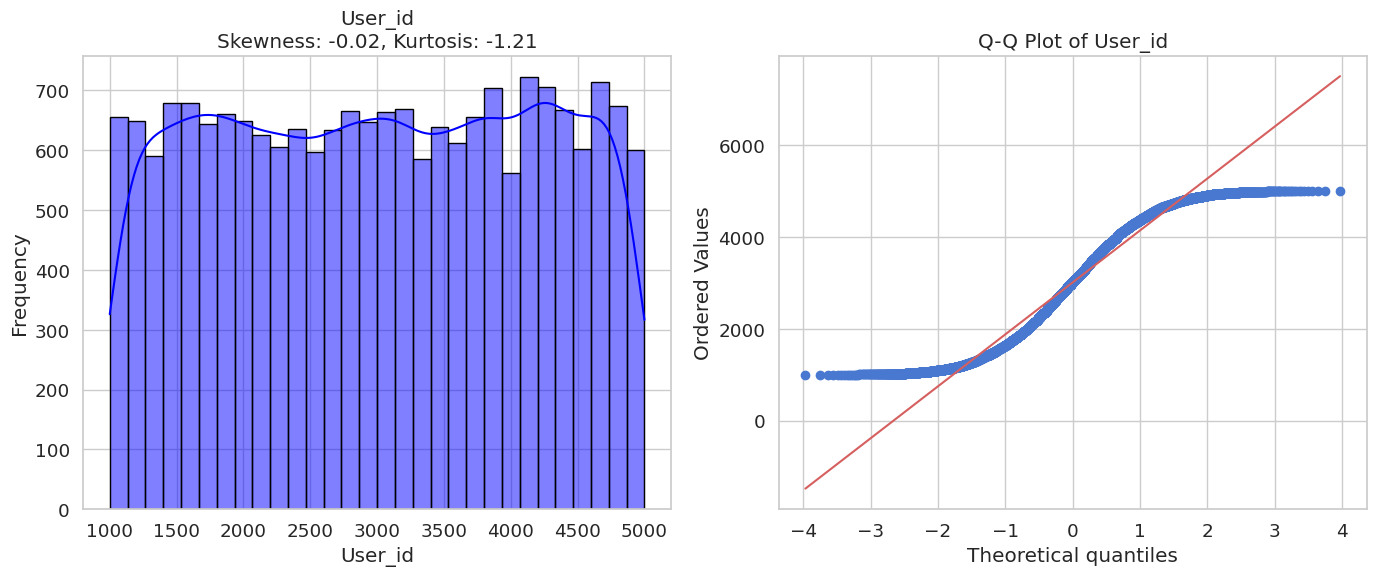

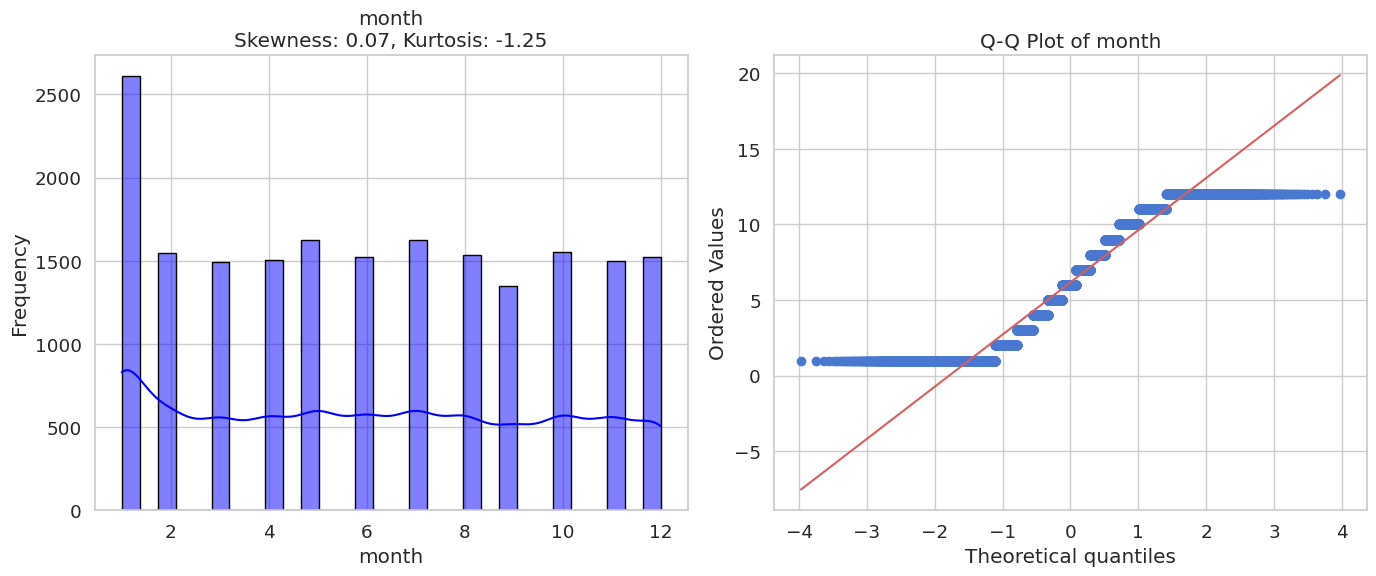

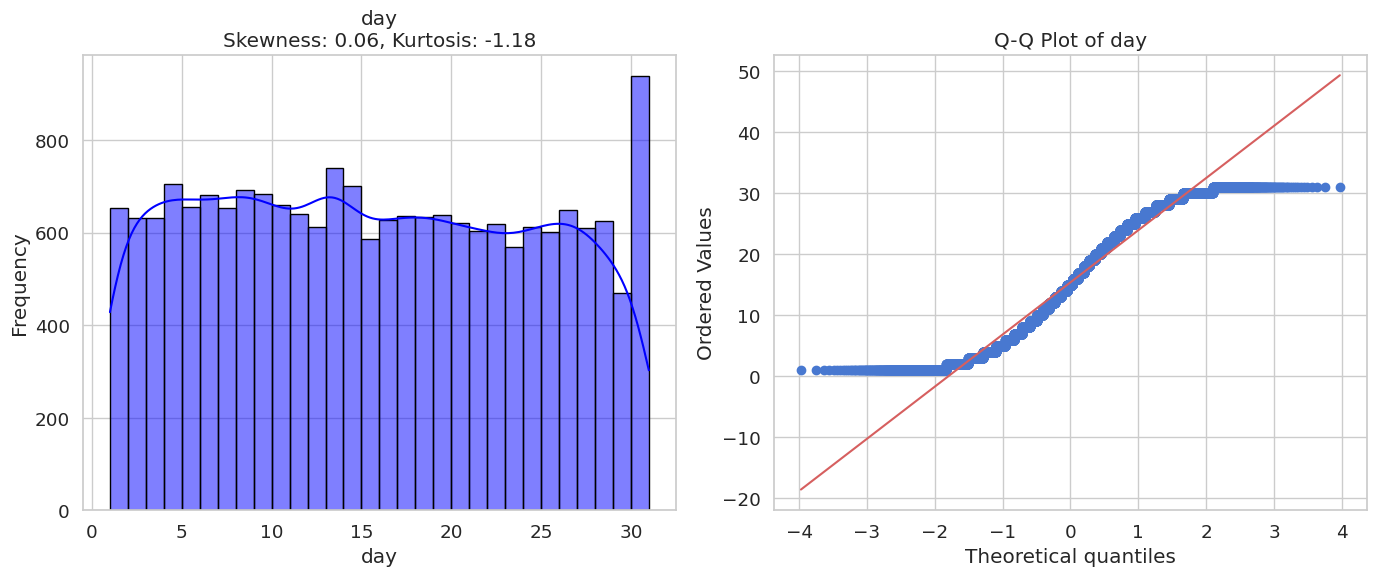

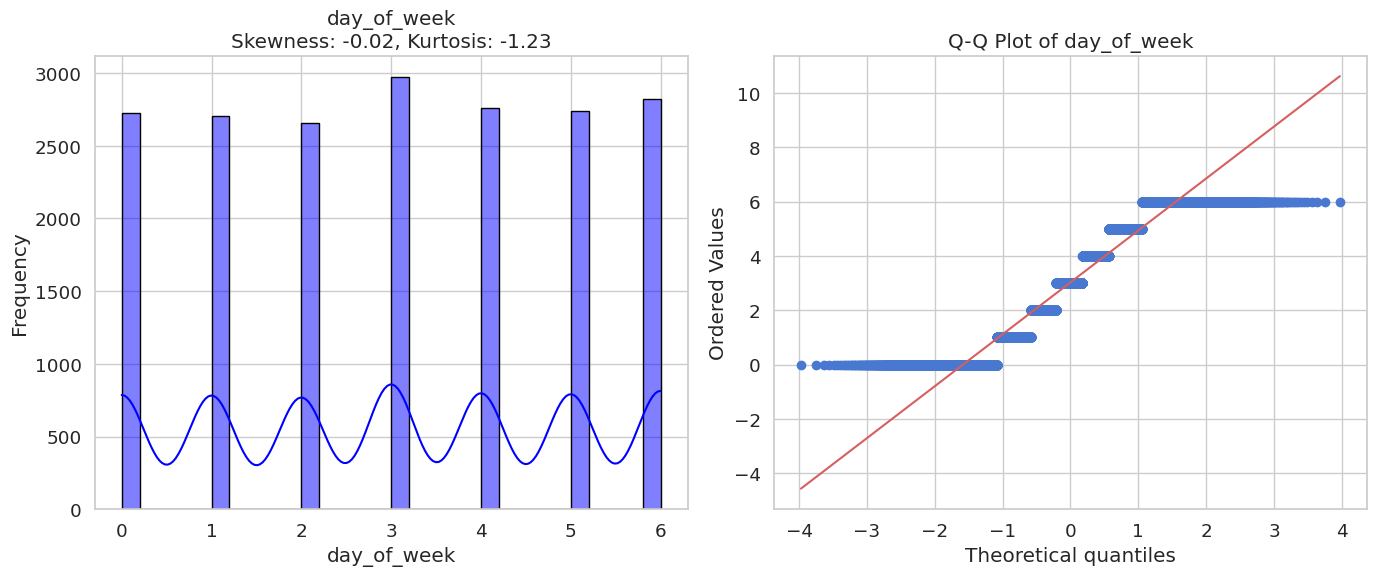

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#formating the plot
sns.set(style="whitegrid",palette = "muted",font_scale=1.2)

#selecting the numerical features
exclude_col = ['year']
num_cols = [col for col in df.select_dtypes(include=np.number).columns if col not in exclude_col]

for col in num_cols:
    plt.figure(figsize=(14,6))

    # Histogram + KDE
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True, color='blue', edgecolor='black')
    skew = df[col].skew()
    kurt = df[col].kurt()
    plt.title(f"{col}\nSkewness: {skew:.2f}, Kurtosis: {kurt:.2f}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

    # Q-Q plot
    plt.subplot(1,2,2)
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")

    #Formating the display
    plt.tight_layout()
    plt.show()

From the above histogram, we can infer that the data is normally distributed over the various points and we dont obser any heavy skewness for all the numeric feature except year.



*   **Checking missing values:**

  the dataset used may contain some NAN values whcih need to be captured and modelled before proceeding to deployment of model. Here, we are using heatmap visualization to do the same. and if missing values are found, we will drop them or replace them with meaning values.



Checking for the null values across all features:


,0
User_id,0
Date,0
itemDescription,0
year,0
month,0
day,0
day_of_week,0


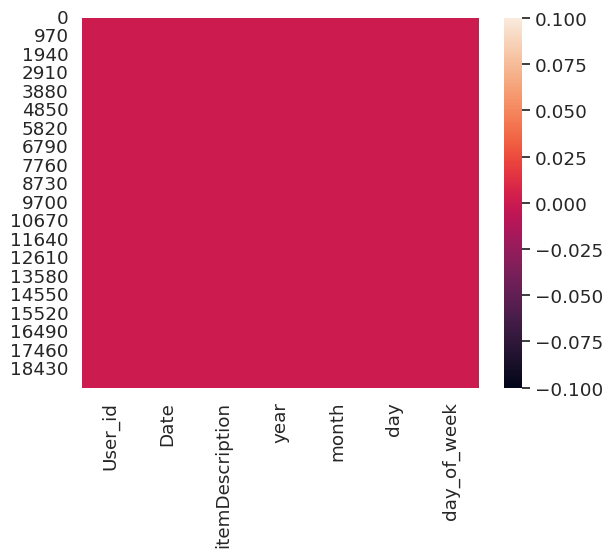

In [5]:
#cheacking for null values
sns.heatmap(df.isnull())
print("Checking for the null values across all features:")
df.isnull().sum()



  * **Checking for outliers:**

  One of the important pre-processing step involves checking how each data points are near by to each other. that means to inspect if any of the point deviates from the normal trend of the feature.






    

*   **Date Time-series plot:**

   The dataset contains the timestamps so it is important to detect the number of transactions going on in a particular day. We can simply groupby on the daily basis and then check for the stationary or moving trends in time series plot.



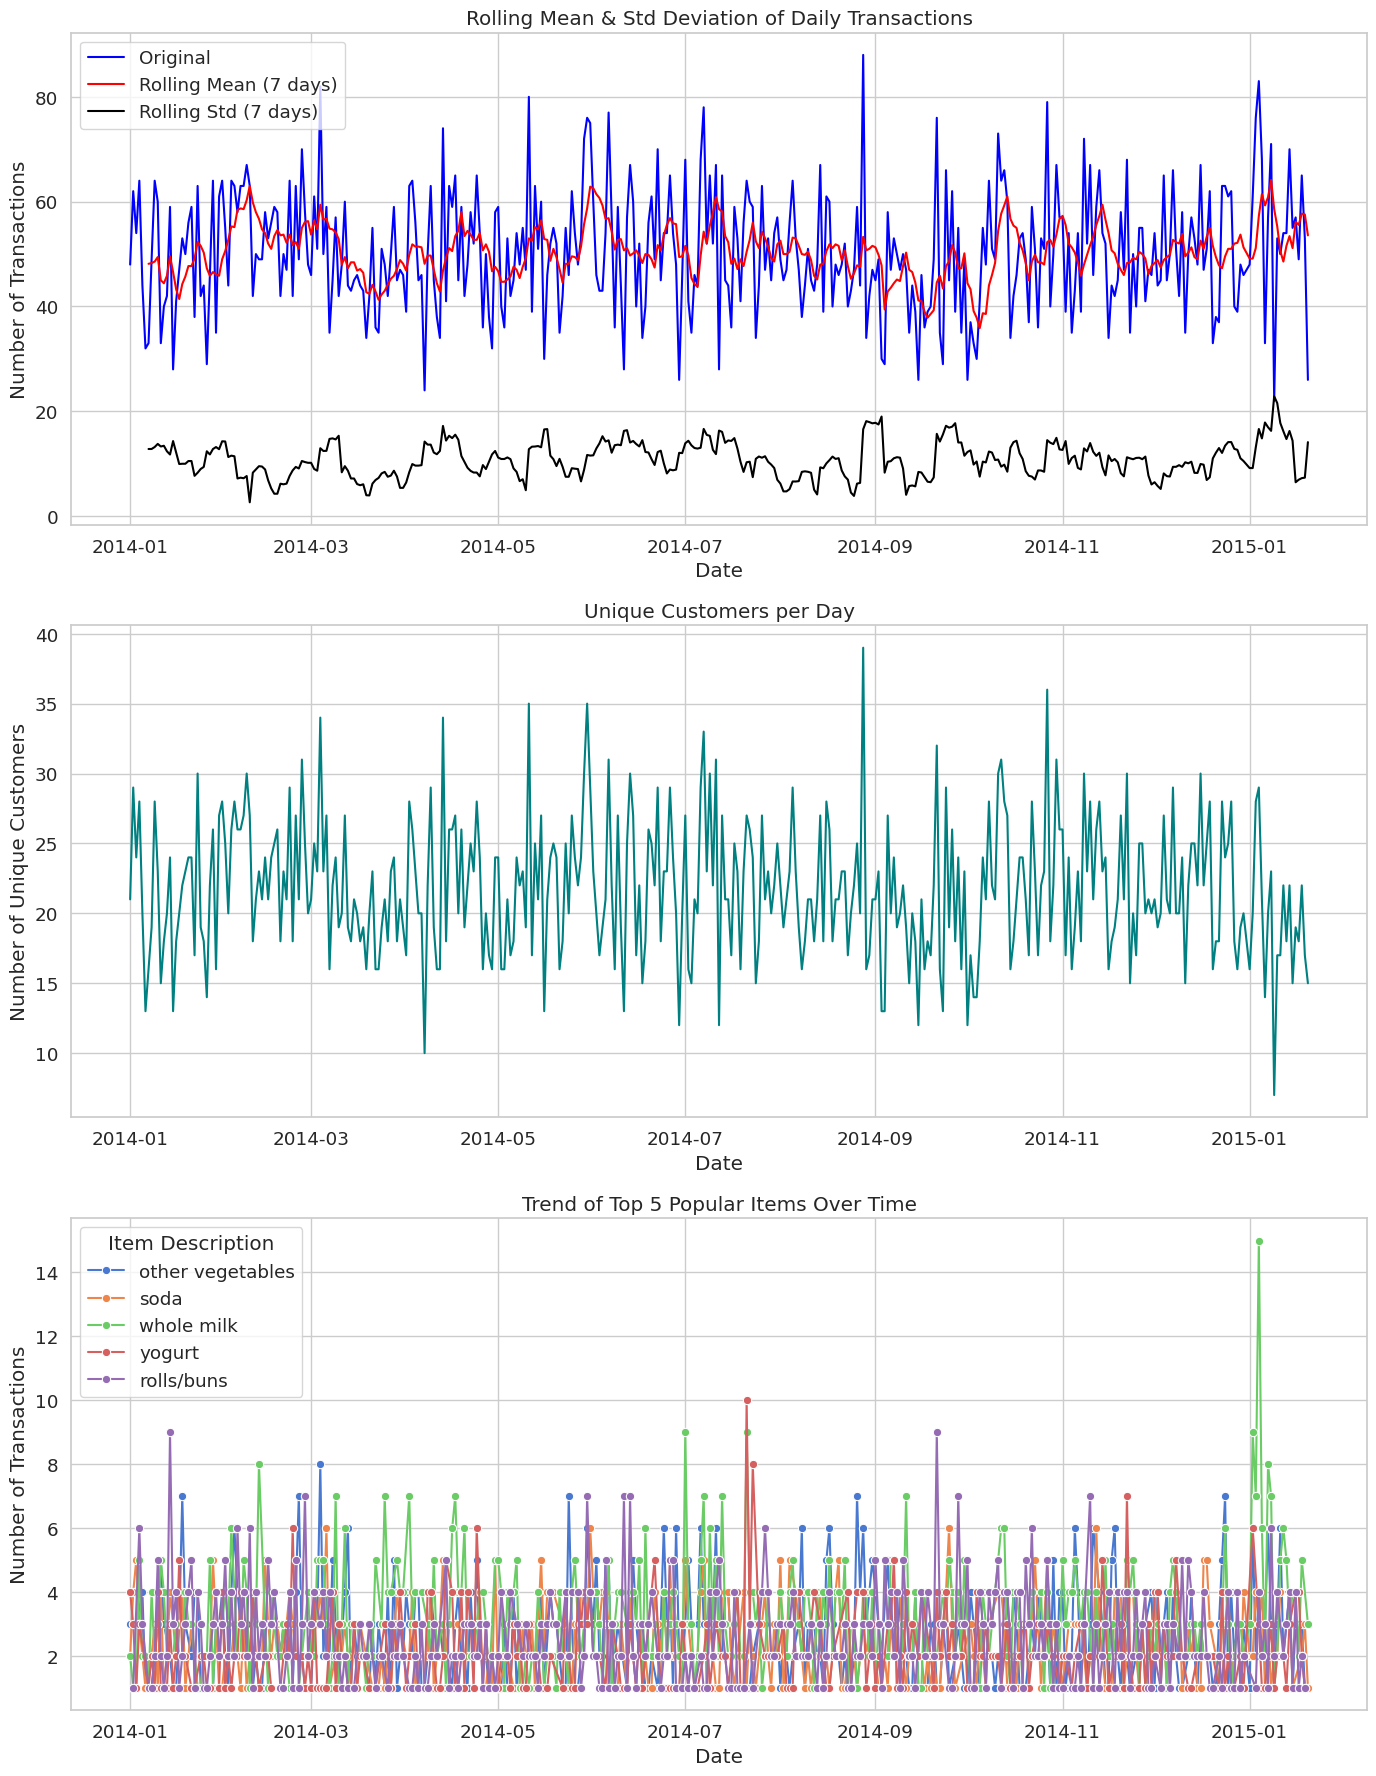

In [6]:

# Converting date to the required format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# 1. Daily transactions
daily_transactions = df.groupby('Date').size()
rolling_mean = daily_transactions.rolling(window=7).mean()
rolling_std = daily_transactions.rolling(window=7).std()

# 2. Unique customers per day
unique_customers_per_day = df.groupby('Date')['User_id'].nunique()

# 3. Popular items trend
top_items = df['itemDescription'].value_counts().head(5).index
filtered_df = df[df['itemDescription'].isin(top_items)]
item_trend = filtered_df.groupby(['Date', 'itemDescription']).size().reset_index(name='Count')

# 📈 Plot all in subplots
fig, axes = plt.subplots(3, 1, figsize=(14,18))

# Plot 1: Rolling transactions per day
axes[0].plot(daily_transactions, color='blue', label='Original')
axes[0].plot(rolling_mean, color='red', label='Rolling Mean (7 days)')
axes[0].plot(rolling_std, color='black', label='Rolling Std (7 days)')
axes[0].set_title('Rolling Mean & Std Deviation of Daily Transactions')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Transactions')
axes[0].legend()

# Plot 2: Unique customers per day
sns.lineplot(x=unique_customers_per_day.index, y=unique_customers_per_day.values,
             color='teal', ax=axes[1])
axes[1].set_title('Unique Customers per Day')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Unique Customers')

# Plot 3: Top items trend
sns.lineplot(data=item_trend, x='Date', y='Count', hue='itemDescription', marker='o', ax=axes[2])
axes[2].set_title('Trend of Top 5 Popular Items Over Time')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Number of Transactions')
axes[2].legend(title='Item Description')

plt.tight_layout()
plt.show()


PLOT 1: In above code spinet, we made use of rolling mean and rolling standard
deviation. As the plot clearly shows that the line for rolling mean and rolling std is not constant and is wavy (upside-downside) depicts non-stationary trend.
Also up to some extend, the number of transaction for most of the days are nearly in same range between 80 to 30, explains the uniform nature of per day transaction

PLOT 2: The chart shows the number of unique customers number in a particular day.

PLOT 3: This chart is important as it shows the number of most popular items over the time period. The top 5 most propular items include milk, other vegetables, soda, yogurt and rolls.

So we can now get the number of unique transactions possessed in the dataset with the followiung code line:


In [7]:
df['itemDescription'] = df['itemDescription'].str.lower()
all_transactions = [transaction[1]['itemDescription'].tolist()
for transaction in list(df.groupby(['User_id', 'Date']))]
print("The number of unique transactions are:" ,len(all_transactions))

The number of unique transactions are: 8361


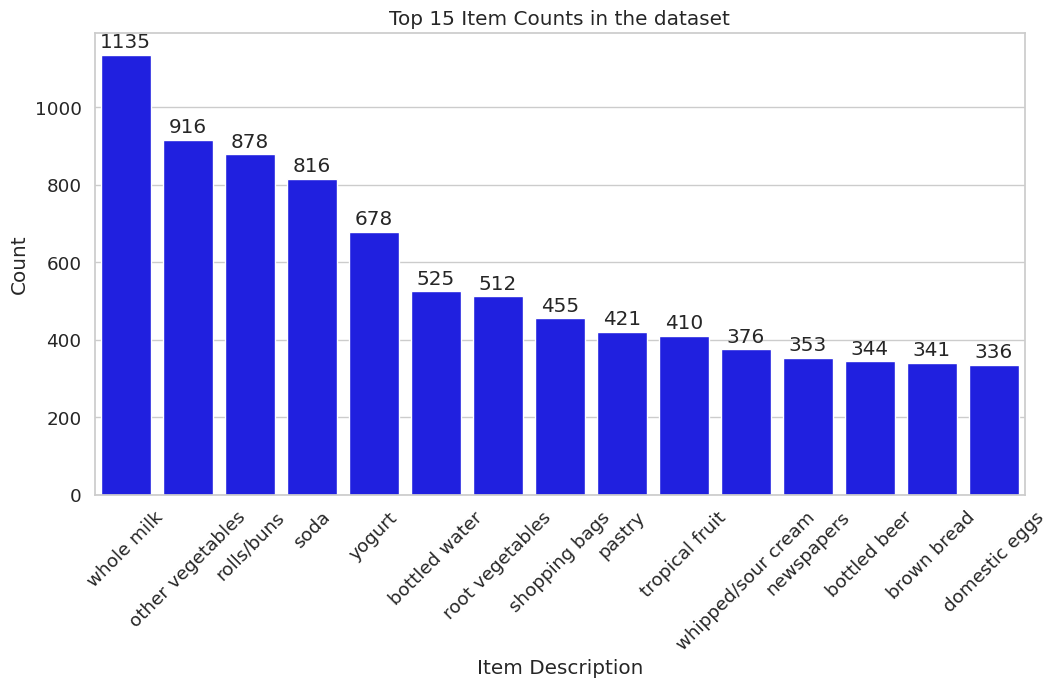

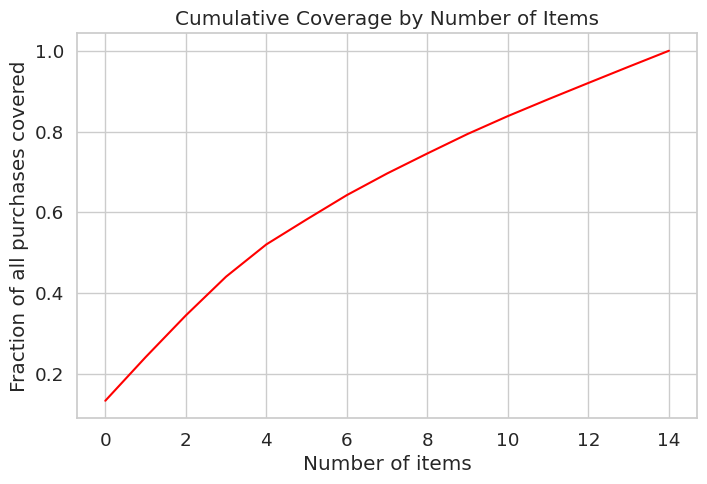

In [8]:
top_15_items = df['itemDescription'].value_counts().nlargest(15)

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=top_15_items.index, y=top_15_items.values,color = "Blue")
plt.xticks(rotation=45)
plt.xlabel("Item Description")
plt.ylabel("Count")
plt.title("Top 15 Item Counts in the dataset")

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

#plot to show how these popular item contributes the basket
cum_coverage = top_15_items.cumsum() / top_15_items.sum()
plt.figure(figsize=(8,5))
plt.plot(cum_coverage.values,color="red")
plt.title('Cumulative Coverage by Number of Items')
plt.xlabel('Number of items')
plt.ylabel('Fraction of all purchases covered')
plt.show()

The second graph helps to show how the top 15 popular items contribute to the fraction of purchases made while grocery shopping. this helps to identify and maintain the count long tailed items (the items that remains unsold)

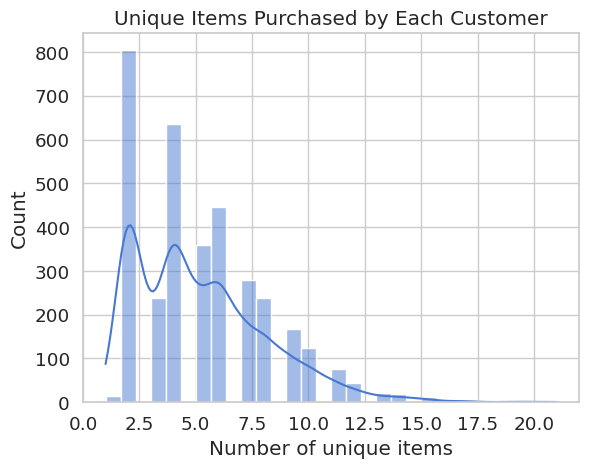

In [9]:
customer_diversity = df.groupby('User_id')['itemDescription'].nunique()
sns.histplot(customer_diversity, bins=30, kde=True)
plt.title('Unique Items Purchased by Each Customer')
plt.xlabel('Number of unique items')
plt.show()



*  **Seasonality Trend of purchased products**



  *   Monthly Basis
  *   Weekly Basis
  *   Quaterly Basis










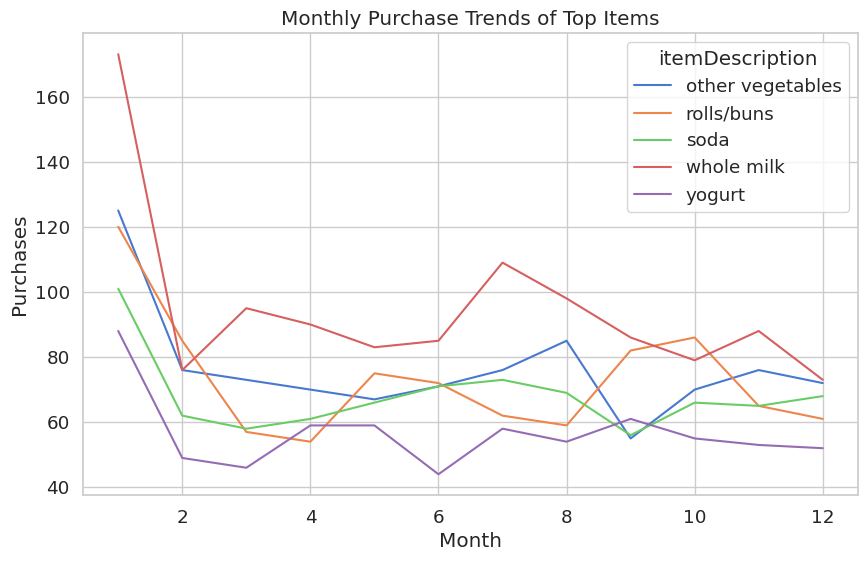

In [10]:
#monthly trend of trending product
df['month'] = df['Date'].dt.month
top_items = df['itemDescription'].value_counts().head(5).index
monthly_trends = df[df['itemDescription'].isin(top_items)].groupby(['month', 'itemDescription']).size().unstack().fillna(0)

monthly_trends.plot(kind='line', figsize=(10,6))
plt.title('Monthly Purchase Trends of Top Items')
plt.xlabel('Month')
plt.ylabel('Purchases')
plt.show()

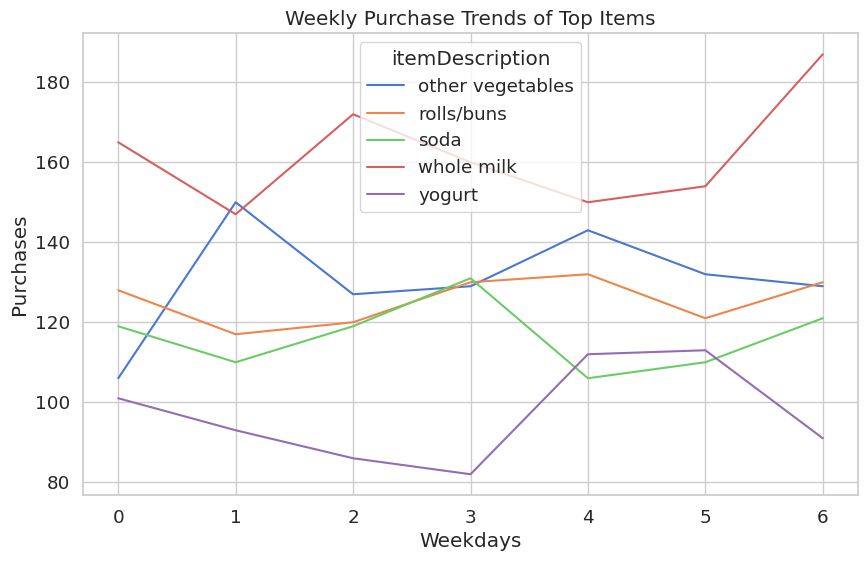

In [11]:
#weekly trend of trending product
top_items = df['itemDescription'].value_counts().head(5).index
monthly_trends = df[df['itemDescription'].isin(top_items)].groupby(['day_of_week', 'itemDescription']).size().unstack().fillna(0)

monthly_trends.plot(kind='line', figsize=(10,6))
plt.title('Weekly Purchase Trends of Top Items')
plt.xlabel('Weekdays')
plt.ylabel('Purchases')
plt.show()

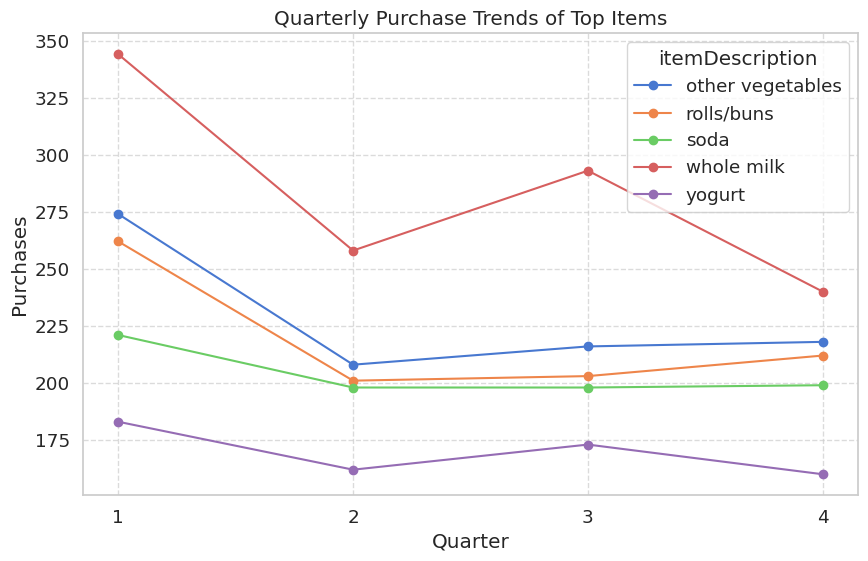

In [12]:
#quaterly trend of trending product
df['quarter'] = ((df['month'] - 1) // 3) + 1
quarterly_trends = (df[df['itemDescription'].isin(top_items)].groupby(['quarter', 'itemDescription']).size().unstack().fillna(0))

quarterly_trends.plot(kind='line', figsize=(10,6), marker='o')
plt.title('Quarterly Purchase Trends of Top Items')
plt.xlabel('Quarter')
plt.ylabel('Purchases')
plt.xticks(quarterly_trends.index)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**Customer Segmentation and Analysis**

Not all customers buy the same things:

Families vs singles → buy in bulk vs small packs.

Health-conscious vs snackers → fruits vs chips.

Weekly vs monthly shoppers.

In [13]:
latest_date = df['Date'].max()

# Build customer-level features
customer_features = df.groupby('User_id').agg(
    total_baskets=('Date', 'nunique'),
    total_items=('itemDescription', 'count'),
    unique_items=('itemDescription', 'nunique'),
    last_purchase=('Date', 'max')
)

# Calculate recency
customer_features['recency'] = (latest_date - customer_features['last_purchase']).dt.days

# Avg basket size
customer_features['avg_basket_size'] = round(customer_features['total_items'] / customer_features['total_baskets'],2)

# Drop last_purchase
customer_features = customer_features.drop(columns='last_purchase')
customer_features.head()

,total_baskets,total_items,unique_items,recency,avg_basket_size
User_id,,,,,
1000,1,3,3,210,3.00
1001,3,7,5,0,2.33
1002,2,4,4,140,2.00
1003,3,6,5,97,2.00
1004,7,19,15,99,2.71


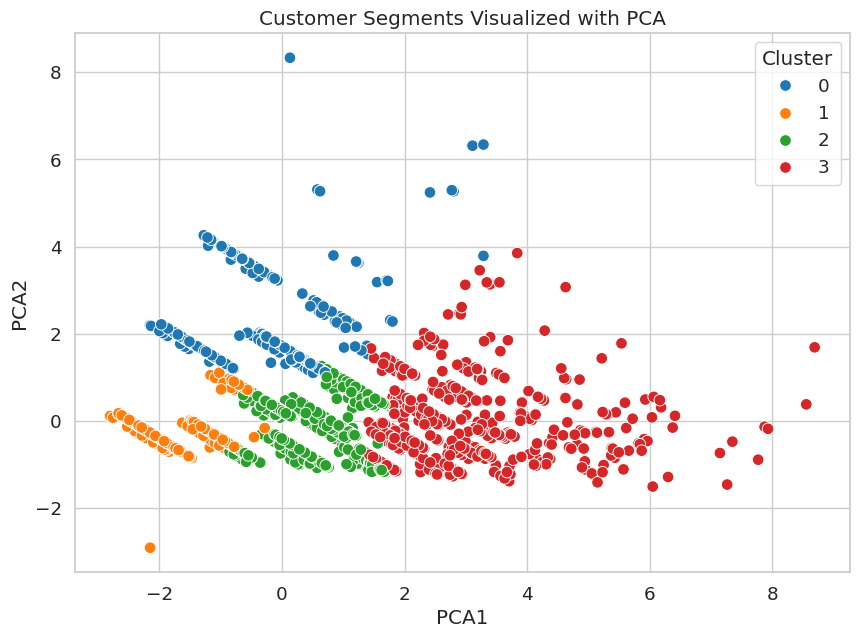

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customer_features)

# Simple K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
customer_features['cluster'] = kmeans.fit_predict(X_scaled)

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
customer_features['PCA1'] = X_pca[:,0]
customer_features['PCA2'] = X_pca[:,1]

plt.figure(figsize=(10,7))
sns.scatterplot(data=customer_features, x='PCA1', y='PCA2', hue='cluster', palette='tab10', s=70)
plt.title('Customer Segments Visualized with PCA')
plt.legend(title='Cluster')
plt.show()

So we can say:

Cluster 0 = your most loyal, high-frequency shoppers.

Cluster 1 = decent repeat buyers, maybe families buying big but less often.

Cluster 2 = newer, small basket shoppers — opportunity to grow.

Cluster 3 = likely churned, rarely shop.

### **PART C: MODELLING**

### **FIRST APPROACH :**

**Recommendation provided based on User past purchase**

This is the method that is more personalised way of providing the advice of which items need to be selected based on their past n-purchases. This helps us to understand more clearly the semantics of the user choices. We can adopt this approach by grouping all the transactions of a particular user using feature engineering and implementing RFM logic to it.

In [15]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

#dataframe for every user purchase history
user_history = df.groupby('User_id')['itemDescription'].apply(list)

In [16]:
user_history.head(5)

,itemDescription
User_id,
1000,"[whole milk, pastry, salty snack]"
1001,"[sausage, whole milk, rolls/buns, whole milk, ..."
1002,"[butter, whole milk, frozen vegetables, other ..."
1003,"[frozen meals, dental care, rolls/buns, rolls/..."
1004,"[dish cleaner, cling film/bags, canned beer, f..."


now simply based on past purchase, we will first find out which items are bought most frequently and then suggesting them to user assuming that they like those product most.

And suggest those items also which were bought early but not bought recently.

In [17]:
def smart_grocery_recommendation(user_id, df, top_n=5, recent_days=30):

    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
    latest_date = df['Date'].max()
    user_data = df[df['User_id'] == user_id].sort_values('Date')

    # Based on frequent history
    top_frequent_items = user_data['itemDescription'].value_counts().head(top_n).index.tolist()

    # Based on recently missed
    recent_items = user_data[user_data['Date'] > latest_date - pd.Timedelta(days=recent_days)]['itemDescription'].unique()
    top_items_all_time = user_data['itemDescription'].value_counts().index
    recently_missed_items = [item for item in top_items_all_time if item not in recent_items][:top_n]

    # Based on co-purchases
    co_purchase_items = []
    if len(top_frequent_items) > 0:
        favorite_item = top_frequent_items[0]
        purchase_dates_with_fav = user_data[user_data['itemDescription']==favorite_item]['Date'].unique()
        co_items = df[df['Date'].isin(purchase_dates_with_fav) & (df['itemDescription'] != favorite_item)]
        co_purchase_items = co_items['itemDescription'].value_counts().head(top_n).index.tolist()


    print(f"\n Recommendations for User {user_id}")
    print("\n➡ Based on frequent history:")
    print(f"  {top_frequent_items if top_frequent_items else 'No history found.'}")

    print("\n➡ Based on recently missed favorites:")
    print(f"  {recently_missed_items if recently_missed_items else 'Nothing missed recently.'}")

    print(f"\n➡ Based on items often bought with '{favorite_item if len(top_frequent_items)>0 else ''}':")
    print(f"  {co_purchase_items if co_purchase_items else 'No co-purchase pattern found.'}")


smart_grocery_recommendation(1001, df)



 Recommendations for User 1001

➡ Based on frequent history:
  ['whole milk', 'soda', 'sausage', 'rolls/buns', 'frankfurter']

➡ Based on recently missed favorites:
  ['whole milk', 'sausage', 'rolls/buns']

➡ Based on items often bought with 'whole milk':
  ['other vegetables', 'soda', 'rolls/buns', 'fruit/vegetable juice', 'domestic eggs']


implementation of KNN algorithm:

In [28]:
from sklearn.neighbors import NearestNeighbors

user_item_matrix = pd.crosstab(df['User_id'], df['itemDescription'])
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_item_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [33]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Split last 14 days for test
cutoff_date = df['Date'].max() - pd.Timedelta(days=14)
df_train = df[df['Date'] <= cutoff_date]
df_test = df[df['Date'] > cutoff_date]

# Train user-item matrix
user_item_matrix_train = pd.crosstab(df_train['User_id'], df_train['itemDescription'])

# Re-train KNN
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_item_matrix_train)

NearestNeighbors(algorithm='brute', metric='cosine')

In [34]:
def recommend_knn_list(user_id, model_knn, user_item_matrix, n_recs=5):
    if user_id not in user_item_matrix.index:
        return []

    user_vector = user_item_matrix.loc[[user_id]]
    distances, indices = model_knn.kneighbors(user_vector, n_neighbors=6)
    neighbors = user_item_matrix.index[indices.flatten()][1:]

    neighbor_data = user_item_matrix.loc[neighbors].sum().sort_values(ascending=False)
    already_bought = user_item_matrix.loc[user_id]
    recommendations = neighbor_data[already_bought == 0].head(n_recs).index.tolist()

    return recommendations


In [35]:
print(recommend_knn_list(1001, model_knn, user_item_matrix))

['bottled beer', 'butter milk', 'butter', 'candy', 'cream cheese ']


In [37]:
def evaluate_knn_model(model_knn, user_item_matrix_train, df_test, k=5, sample_size=100):
    import numpy as np

    precision_scores = []
    recall_scores = []
    reciprocal_ranks = []

    common_users = set(df_test['User_id']) & set(user_item_matrix_train.index)
    test_users = list(common_users)[:sample_size]

    for user_id in test_users:
        actual_items = set(df_test[df_test['User_id'] == user_id]['itemDescription'])
        if not actual_items:
            continue

        recommended_items = recommend_knn_list(user_id, model_knn, user_item_matrix_train, n_recs=k)
        if not recommended_items:
            continue

        recommended_set = set(recommended_items)
        true_positives = recommended_set & actual_items

        # Precision@K
        precision = len(true_positives) / k
        precision_scores.append(precision)

        # Recall@K
        recall = len(true_positives) / len(actual_items)
        recall_scores.append(recall)

        # MRR
        rr = 0
        for rank, item in enumerate(recommended_items, start=1):
            if item in actual_items:
                rr = 1 / rank
                break
        reciprocal_ranks.append(rr)

    # Averages
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    f1 = 2 * avg_precision * avg_recall / (avg_precision + avg_recall + 1e-9)
    mrr = np.mean(reciprocal_ranks)

    print(f"Evaluation for KNN Recommender (k={k}):")
    print(f"Precision@{k}: {avg_precision:.4f}")
    print(f"Recall@{k}:    {avg_recall:.4f}")
    print(f"F1-Score@{k}:  {f1:.4f}")
    print(f"MRR:           {mrr:.4f}")

    return {
        "Precision@K": avg_precision,
        "Recall@K": avg_recall,
        "F1-Score@K": f1,
        "MRR": mrr
    }
evaluate_knn_model(model_knn, user_item_matrix_train, df_test, k=5, sample_size=100)


Evaluation for KNN Recommender (k=5):
Precision@5: 0.0480
Recall@5:    0.0729
F1-Score@5:  0.0579
MRR:           0.1118


{'Precision@K': np.float64(0.048),
 'Recall@K': np.float64(0.07285714285714284),
 'F1-Score@K': np.float64(0.05787233994668276),
 'MRR': np.float64(0.11183333333333334)}

### **SECOND APPROACH**

### **Content based recommendation**
This approach make use of TF-IDF algorithm to find the recomendations for the product based on basket items. for example if a customer buys ABC items then we provide a list of few XYZ suggestions which are related to that items using advanced machine learning models.

In [ ]:
!pip install mlxtend

In [45]:
def recommend_content_list(user_id, user_profiles, user_tfidf_matrix, item_names, item_tfidf_matrix, df, top_n=5):
    try:
        idx = user_profiles[user_profiles['User_id'] == user_id].index[0]
    except IndexError:
        return []

    user_vec = user_tfidf_matrix[idx]
    similarities = cosine_similarity(user_vec, item_tfidf_matrix).flatten()

    items_bought = set(df[df['User_id'] == user_id]['itemDescription'].tolist())

    recommendations = pd.DataFrame({
        'item': item_names,
        'score': similarities
    })
    recommendations = recommendations[~recommendations['item'].isin(items_bought)]
    top_recs = recommendations.sort_values('score', ascending=False).head(top_n)

    return top_recs['item'].tolist()


In [47]:
def evaluate_content_model(user_profiles_train, user_tfidf_matrix_train,
                           item_names, item_tfidf_matrix_train,
                           df_train, df_test,
                           top_k=5, sample_size=100):
    import numpy as np

    precision_scores = []
    recall_scores = []
    reciprocal_ranks = []

    test_users = list(set(df_test['User_id']) & set(user_profiles_train['User_id']))[:sample_size]

    for user_id in test_users:
        actual_items = set(df_test[df_test['User_id'] == user_id]['itemDescription'])
        if not actual_items:
            continue

        recommended_items = recommend_content_list(
            user_id,
            user_profiles_train,
            user_tfidf_matrix_train,
            item_names,
            item_tfidf_matrix_train,
            df_train,
            top_n=top_k
        )

        if not recommended_items:
            continue

        recommended_set = set(recommended_items)
        true_positives = recommended_set & actual_items

        precision = len(true_positives) / top_k
        recall = len(true_positives) / len(actual_items)

        rr = 0
        for rank, item in enumerate(recommended_items, start=1):
            if item in actual_items:
                rr = 1 / rank
                break

        precision_scores.append(precision)
        recall_scores.append(recall)
        reciprocal_ranks.append(rr)

    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    f1 = 2 * avg_precision * avg_recall / (avg_precision + avg_recall + 1e-9)
    mrr = np.mean(reciprocal_ranks)

    print(f"Content-Based Model Evaluation (top-{top_k}):")
    print(f"Precision@{top_k}: {avg_precision:.4f}")
    print(f"Recall@{top_k}:    {avg_recall:.4f}")
    print(f"F1-Score@{top_k}:  {f1:.4f}")
    print(f"MRR:               {mrr:.4f}")

    return {
        "Precision@K": avg_precision,
        "Recall@K": avg_recall,
        "F1-Score@K": f1,
        "MRR": mrr
    }

evaluate_content_model(user_profiles_train, user_tfidf_matrix_train,
                       item_names, item_tfidf_matrix_train,
                       df_train, df_test, top_k=5, sample_size=100)

Content-Based Model Evaluation (top-5):
Precision@5: 0.0140
Recall@5:    0.0187
F1-Score@5:  0.0160
MRR:               0.0283


{'Precision@K': np.float64(0.014000000000000002),
 'Recall@K': np.float64(0.01875),
 'F1-Score@K': np.float64(0.01603053386166309),
 'MRR': np.float64(0.028333333333333332)}

This content-based recommendation model uses TF-IDF to learn user preferences from past purchases by representing items as weighted text vectors. It calculates cosine similarity between user profiles and available items to suggest products that are most similar to their history, enabling personalized and scalable recommendations for unseen data.

### **HYBRID APPROACH**
(Collaborative filtering + Content based Filtering)

In [50]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

def content_based_scores(user_id, user_profiles, user_tfidf_matrix, item_names, item_tfidf_matrix, df):
    try:
        idx = user_profiles[user_profiles['User_id'] == user_id].index[0]
    except IndexError:
        return pd.Series()

    user_vec = user_tfidf_matrix[idx]
    similarities = cosine_similarity(user_vec, item_tfidf_matrix).flatten()

    items_bought = set(df[df['User_id'] == user_id]['itemDescription'].tolist())
    cbf_scores = pd.Series(similarities, index=item_names)
    cbf_scores = cbf_scores[~cbf_scores.index.isin(items_bought)]

    if cbf_scores.max() > 0:
        cbf_scores = cbf_scores / cbf_scores.max()
    return cbf_scores

def knn_scores(user_id, model_knn, user_item_matrix):
    if user_id not in user_item_matrix.index:
        return pd.Series()

    user_vector = user_item_matrix.loc[[user_id]]
    distances, indices = model_knn.kneighbors(user_vector, n_neighbors=model_knn.n_neighbors)
    neighbors = user_item_matrix.index[indices.flatten()][1:]
    neighbor_data = user_item_matrix.loc[neighbors].sum()

    already_bought = user_item_matrix.loc[user_id]
    cf_scores = neighbor_data[already_bought == 0]

    if cf_scores.max() > 0:
        cf_scores = cf_scores / cf_scores.max()
    return cf_scores




In [51]:
def hybrid_recommendation(user_id,
                          user_profiles, user_tfidf_matrix, item_names, item_tfidf_matrix, df,
                          model_knn, user_item_matrix,
                          alpha=0.5, top_n=5):
    cbf = content_based_scores(user_id, user_profiles, user_tfidf_matrix, item_names, item_tfidf_matrix, df)
    cf = knn_scores(user_id, model_knn, user_item_matrix)

    all_items = set(cbf.index).union(cf.index)
    cbf = cbf.reindex(all_items).fillna(0)
    cf = cf.reindex(all_items).fillna(0)

    hybrid_scores = alpha * cbf + (1 - alpha) * cf
    hybrid_scores = hybrid_scores.sort_values(ascending=False).head(top_n)
    return hybrid_scores

In [52]:
df = pd.read_csv("Groceries data train.csv")
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

def train_test_split_user(df, test_size=0.2):
    train_list = []
    test_list = []
    for user_id, group in df.groupby('User_id'):
        if len(group) > 1:
            train_grp, test_grp = train_test_split(group, test_size=test_size, random_state=42)
            train_list.append(train_grp)
            test_list.append(test_grp)
        else: # Handle users with only one purchase
            train_list.append(group)
    return pd.concat(train_list), pd.concat(test_list)

df_train, df_test = train_test_split_user(df)

# Content-based setup on train data
user_profiles = df_train.groupby('User_id')['itemDescription'].apply(lambda x: ' '.join(x)).reset_index()
tfidf = TfidfVectorizer()
user_tfidf_matrix = tfidf.fit_transform(user_profiles['itemDescription'])

item_names = df_train['itemDescription'].unique().tolist()
item_tfidf_matrix = tfidf.transform(item_names)

# Collaborative filtering setup on train data
user_item_matrix = pd.crosstab(df_train['User_id'], df_train['itemDescription'])

# Evaluation metric: Precision@k
def precision_at_k(recommended_items, true_items, k=5):
    recommended_set = set(recommended_items[:k])
    true_set = set(true_items)
    if not recommended_set:
        return 0.0
    return len(recommended_set.intersection(true_set)) / len(recommended_set)

Hybrid Recommendations for User 1001 (α=0.6):

 butter milk (score: 0.60)
 UHT-milk (score: 0.50)
 organic sausage (score: 0.50)
 frozen vegetables (score: 0.40)
 salty snack (score: 0.40)


In [53]:
import numpy as np

def evaluate_hybrid_model(df_test, user_profiles, user_tfidf_matrix, item_names, item_tfidf_matrix,
                          model_knn, user_item_matrix, k=5, alpha=0.5, sample_size=100):

    precision_scores = []
    recall_scores = []
    f1_scores = []
    reciprocal_ranks = []

    # Use only users present in both train and test
    test_users = list(set(df_test['User_id']) & set(user_profiles['User_id']))
    test_users = test_users[:sample_size]

    for user_id in test_users:
        true_items = df_test[df_test['User_id'] == user_id]['itemDescription'].tolist()
        if not true_items:
            continue

        # Get top-k recommendations from hybrid
        hybrid_scores = hybrid_recommendation(
            user_id, user_profiles, user_tfidf_matrix,
            item_names, item_tfidf_matrix,
            df_train, model_knn, user_item_matrix,
            alpha=alpha, top_n=k
        )

        recommended_items = hybrid_scores.index.tolist()
        if not recommended_items:
            continue

        recommended_set = set(recommended_items)
        true_set = set(true_items)

        # Precision@k
        precision = len(recommended_set & true_set) / k
        precision_scores.append(precision)

        # Recall@k
        recall = len(recommended_set & true_set) / len(true_set)
        recall_scores.append(recall)

        # F1@k
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0.0
        f1_scores.append(f1)

        # MRR
        rr = 0
        for rank, item in enumerate(recommended_items, start=1):
            if item in true_set:
                rr = 1 / rank
                break
        reciprocal_ranks.append(rr)

    # Output average metrics
    print(f"\n Hybrid Recommender Evaluation (alpha={alpha}, top-{k}):")
    print(f"Precision@{k}: {np.mean(precision_scores):.4f}")
    print(f" Recall@{k}:    {np.mean(recall_scores):.4f}")
    print(f"F1-Score@{k}:  {np.mean(f1_scores):.4f}")
    print(f"MRR:           {np.mean(reciprocal_ranks):.4f}")

    return {
        'Precision@K': np.mean(precision_scores),
        'Recall@K': np.mean(recall_scores),
        'F1-Score@K': np.mean(f1_scores),
        'MRR': np.mean(reciprocal_ranks)
    }

evaluate_hybrid_model(
    df_test=df_test,
    user_profiles=user_profiles,
    user_tfidf_matrix=user_tfidf_matrix,
    item_names=item_names,
    item_tfidf_matrix=item_tfidf_matrix,
    model_knn=model_knn,
    user_item_matrix=user_item_matrix,
    k=5,
    alpha=0.5,
    sample_size=100
)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Instant food products
- UHT-milk
Feature names seen at fit time, yet now missing:
- baby cosmetics
- frozen chicken
- instant food products
- uht-milk


HYPER-PARAMETER TUNING:

Alpha and n_neighbors are key hyperparameters for balancing hybrid scores and neighborhood size.

Precision@k is an interpretable, standard metric for recommendation quality.


In [ ]:
alphas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
neighbors_list = [3, 5, 7, 10]

results = []

test_user_ids = df_test['User_id'].unique()

for n_neighbors in neighbors_list:
    # Train KNN model
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors)
    model_knn.fit(user_item_matrix)

    for alpha in alphas:
        precisions = []

        for user_id in test_user_ids:
            # Skip if user not in train data
            if user_id not in user_item_matrix.index:
                continue

            # Get recommendations (items + scores)
            rec_scores = hybrid_recommendation(
                user_id=user_id,
                user_profiles=user_profiles,
                user_tfidf_matrix=user_tfidf_matrix,
                item_names=item_names,
                item_tfidf_matrix=item_tfidf_matrix,
                df=df_train,
                model_knn=model_knn,
                user_item_matrix=user_item_matrix,
                alpha=alpha,
                top_n=5
            )

            recommended_items = rec_scores.index.tolist()

            # True items bought by user in test
            true_items = df_test[df_test['User_id'] == user_id]['itemDescription'].unique()

            p = precision_at_k(recommended_items, true_items, k=5)
            precisions.append(p)

        avg_precision = sum(precisions) / len(precisions) if precisions else 0
        results.append({
            'n_neighbors': n_neighbors,
            'alpha': alpha,
            'precision@5': avg_precision
        })
        print(f"Neighbors: {n_neighbors}, Alpha: {alpha:.1f}, Precision@5: {avg_precision:.4f}")


Neighbors: 3, Alpha: 0.0, Precision@5: 0.0142
Neighbors: 3, Alpha: 0.2, Precision@5: 0.0140
Neighbors: 3, Alpha: 0.4, Precision@5: 0.0140
Neighbors: 3, Alpha: 0.6, Precision@5: 0.0125
Neighbors: 3, Alpha: 0.8, Precision@5: 0.0099
Neighbors: 3, Alpha: 1.0, Precision@5: 0.0093
Neighbors: 5, Alpha: 0.0, Precision@5: 0.0175
Neighbors: 5, Alpha: 0.2, Precision@5: 0.0174
Neighbors: 5, Alpha: 0.4, Precision@5: 0.0171
Neighbors: 5, Alpha: 0.6, Precision@5: 0.0137
Neighbors: 5, Alpha: 0.8, Precision@5: 0.0104
Neighbors: 5, Alpha: 1.0, Precision@5: 0.0093
Neighbors: 7, Alpha: 0.0, Precision@5: 0.0198
Neighbors: 7, Alpha: 0.2, Precision@5: 0.0191
Neighbors: 7, Alpha: 0.4, Precision@5: 0.0186
Neighbors: 7, Alpha: 0.6, Precision@5: 0.0147
Neighbors: 7, Alpha: 0.8, Precision@5: 0.0111
Neighbors: 7, Alpha: 1.0, Precision@5: 0.0093
Neighbors: 10, Alpha: 0.0, Precision@5: 0.0221
Neighbors: 10, Alpha: 0.2, Precision@5: 0.0223
Neighbors: 10, Alpha: 0.4, Precision@5: 0.0205
Neighbors: 10, Alpha: 0.6, Prec

In [ ]:
best_result = max(results, key=lambda x: x['precision@5'])
print("\nBest hyperparameters found:")
print(best_result)

# Train final model with best hyperparameters
model_knn_final = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=best_result['n_neighbors'])
model_knn_final.fit(user_item_matrix)

# Example: Get top 5 recommendations for a user with best alpha
example_user = test_user_ids[0]
final_recs = hybrid_recommendation(
    user_id=example_user,
    user_profiles=user_profiles,
    user_tfidf_matrix=user_tfidf_matrix,
    item_names=item_names,
    item_tfidf_matrix=item_tfidf_matrix,
    df=df_train,
    model_knn=model_knn_final,
    user_item_matrix=user_item_matrix,
    alpha=best_result['alpha'],
    top_n=5
)

print(f"\nTop 5 hybrid recommendations for User {example_user} with alpha={best_result['alpha']} and neighbors={best_result['n_neighbors']}:")
for item, score in final_recs.items():
    print(f"{item} (score: {score:.3f})")


Best hyperparameters found:
{'n_neighbors': 10, 'alpha': 0.2, 'precision@5': 0.022343168146663}

Top 5 hybrid recommendations for User 1000 with alpha=0.2 and neighbors=10:
snack products (score: 0.200)
nut snack (score: 0.145)
skin care (score: 0.000)
curd (score: 0.000)
dish cleaner (score: 0.000)
